Note book exploring the gross per week data and attempting to model grossing per week as an exponential decay. Can a movies final gross be reliably predicted given its opening gross and 

In [1]:
# Necessary Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from scipy.optimize import curve_fit
import scipy.stats as stats
import statistics as stat
import matplotlib.cm as cm
from prettytable import PrettyTable
import random

In [17]:
# Load the cleaned movies grossing dataset
df = pd.read_csv("C:/Users/micha/OneDrive/Documents/Grad School 3rd year/Summer 2025/Project Codes/datasets/"+
    "1977-2025_clean.txt",
    sep = '\t')
print(df.columns)

Index(['Movie Title', 'Rank', 'Gross ($)', 'Theater Number',
       'Change in Theater Number', 'Gross to Date', 'Date'],
      dtype='object')


Here we define a linear function and an exponential function. These are used to fit the natural log of the grossing data and the normal grossing data and to estimate decay constants. We also define a function which numerically calculates the total gross based upon the given exponential parameters. 

In [5]:
# linear function for fitting the natural log of the data. Slope will be decay rate and b is
# ln(initial_value)
def linear_func(t, m, b):
    return (-m * t) + b

# exponential function for fitting data. A is initial value and k is decay rate.
def exp_func(t, k, A):
    return A * np.exp(-k*t)

# both functions are writtem so positive decay rates are return.

# function which sums the y value of the exponential fit at each time point
# providing a numerical value for the total gross
def total_gross_calc(A,k):
    x = np.array([i for i in range(1000)])
    y = A*np.exp(-k*x)
    return sum(y)

Here we go through the movies dataframe and collect the necessary information for downstream analysis. We create:
1. grossing_data: a dictionary with movies as keys and grossing per week as the values. 
2. total_gross: a dictionary with movies as keys and total gross as values.
3. total_gross_vals: a list of the total gross values for each movie
4. first_week_gross_vals: a dictionary with movies as keys and the first weeks gross as values
5. first_week_gross_vals: a list of all movies first week gross values
6. decay_rates: a dictionary with movies as keys and their decay rates estimated from fitting their gross per week data to an exponential decay as values.

In [20]:
movies = df['Movie Title'].unique()
grossing_data = {}
total_gross = {}
total_gross_vals = []
first_week_gross = {}
first_week_gross_vals = []
decay_rates = {}
for movie in movies:
    ydata = list(df.loc[df['Movie Title'] == movie]['Gross ($)'])
    # if (ydata[0] == np.max(ydata)) and (int(movie.split(')-rl')[0][-4:]) >= 2000):
    # if (ydata[0] == np.max(ydata)):
    # if 1 == 1:
    if np.max(df.loc[df['Movie Title'] == movie]['Theater Number']) == list(df.loc[df['Movie Title'] == movie]['Theater Number'])[0]:
        ydata = [int(y) for y in ydata]
        dates = list(df.loc[df['Movie Title'] == movie]['Date'])
        xdata = [0]
        for j in range(1,len(dates)):
            xdata += [int((datetime.strptime(dates[j],'%Y-%m-%d')-datetime.strptime(dates[j-1],'%Y-%m-%d')).days/7)+xdata[j-1]]
        grossing_data[movie] = [xdata,ydata]
        decay_rates[movie] = curve_fit(exp_func, np.array(xdata), np.array(ydata), bounds = (0,np.inf))[0][0]
        total_gross[movie] = int(df.loc[df['Movie Title'] == movie]['Gross ($)'].sum())
        total_gross_vals += [int(df.loc[df['Movie Title'] == movie]['Gross ($)'].sum())]
        first_week_gross[movie] = ydata[0]
        first_week_gross_vals += [ydata[0]]
print("number of movies: ",len(grossing_data))
movies = list(grossing_data.keys())


number of movies:  2424


This function accepts a number of groups and divides movies into that many groups based upon their total gross. For example, if 3 groups are specified then movies are divided into tertiles based upon total gross and if 4 groups, quartiles. A list of lists containing the movie titles in their groups is returned along with a list of lists of the total gross values for each group. 

In [32]:
# print statistics of movies for different total grossing groups
def divisions_by_total_gross(number_of_groups):
    if number_of_groups < 2:
        print(" ")
        print("number of groups must be 2 or greater")
    else:
        groups = [[] for i in range(number_of_groups)]
        group_data = [[] for i in range(number_of_groups)]
        print(groups)
        group_boundaries = np.quantile(total_gross_vals,[x/number_of_groups for x in range(1,number_of_groups)])
        print(" ")
        print([x/number_of_groups for x in range(1,number_of_groups)])
        print("Group Boundaries:",group_boundaries)
        
        for movie in movies:
            if total_gross[movie] <= group_boundaries[0]:
                groups[0] += [movie]
                group_data[0] += [total_gross[movie]]
            for i in range(1,number_of_groups-1):
                if (group_boundaries[i-1] < total_gross[movie]) and (total_gross[movie] <= group_boundaries[i]):
                    groups[i] += [movie]
                    group_data[i] += [total_gross[movie]]
            if group_boundaries[-1] < total_gross[movie]:
                groups[-1] += [movie]
                group_data[-1] += [total_gross[movie]]

        table = PrettyTable()
        table.field_names = ["Stats"]+["group"+str(i) for i in range(1,number_of_groups+1)]
        table.add_row(["Mean (million)"]+[round(np.mean(group_data[i])/1000000,3) for i in range(0,number_of_groups)])
        table.add_row(["Median (million)"]+[round(np.median(group_data[i])/1000000,3) for i in range(0,number_of_groups)])
        table.add_row(["N"]+[len(group_data[i]) for i in range(0,number_of_groups)])
        print(" ")
        print("Group Statistics")
        print(table)
        
        return groups, group_data

groups, group_data = divisions_by_total_gross(4)


[[], [], [], []]
 
[0.25, 0.5, 0.75]
Group Boundaries: [ 6983785.75 18109036.5  43794725.25]
 
Group Statistics
+------------------+--------+--------+--------+---------+
|      Stats       | group1 | group2 | group3 |  group4 |
+------------------+--------+--------+--------+---------+
|  Mean (million)  | 3.233  | 12.214 | 29.492 | 127.858 |
| Median (million) | 2.814  |  12.1  | 29.049 |  81.681 |
|        N         |  606   |  606   |  606   |   606   |
+------------------+--------+--------+--------+---------+


This function accepts a number of groups and divides movies into that many groups based upon their first weeks gross. For example, if 3 groups are specified then movies are divided into tertiles based upon first week gross and if 4 groups, quartiles. A list of lists containing the movie titles in their groups is returned along with a list of lists of the first week gross values for each group. 

In [29]:
# print statistics of movies for different week 0 grossing groups
def divisions_by_first_week_gross(number_of_groups):
    if number_of_groups < 2:
        print(" ")
        print("number of groups must be 2 or greater")
    else:
        groups = [[] for i in range(number_of_groups)]
        group_data = [[] for i in range(number_of_groups)]
        print(groups)
        group_boundaries = np.quantile(first_week_gross_vals,[x/number_of_groups for x in range(1,number_of_groups)])
        print(" ")
        print([x/number_of_groups for x in range(1,number_of_groups)])
        print("Group Boundaries:",group_boundaries)
        
        for movie in movies:
            if first_week_gross[movie] <= group_boundaries[0]:
                groups[0] += [movie]
                group_data[0] += [first_week_gross[movie]]
            for i in range(1,number_of_groups-1):
                if (group_boundaries[i-1] < first_week_gross[movie]) and (first_week_gross[movie] <= group_boundaries[i]):
                    groups[i] += [movie]
                    group_data[i] += [first_week_gross[movie]]
            if group_boundaries[-1] < first_week_gross[movie]:
                groups[-1] += [movie]
                group_data[-1] += [first_week_gross[movie]]

        table = PrettyTable()
        table.field_names = ["Stats"]+["group"+str(i) for i in range(1,number_of_groups+1)]
        table.add_row(["Mean (million)"]+[round(np.mean(group_data[i])/1000000,3) for i in range(0,number_of_groups)])
        table.add_row(["Median (million)"]+[round(np.median(group_data[i])/1000000,3) for i in range(0,number_of_groups)])
        table.add_row(["N"]+[len(group_data[i]) for i in range(0,number_of_groups)])
        print(" ")
        print("Group Statistics")
        print(table)
        
        return groups, group_data

groups, group_data = divisions_by_first_week_gross(4)


[[], [], [], []]
 
[0.25, 0.5, 0.75]
Group Boundaries: [ 3625278.   8531773.5 18734834. ]
 
Group Statistics
+------------------+--------+--------+--------+--------+
|      Stats       | group1 | group2 | group3 | group4 |
+------------------+--------+--------+--------+--------+
|  Mean (million)  | 1.671  | 5.852  | 12.896 | 54.135 |
| Median (million) | 1.455  |  5.77  | 12.563 | 33.112 |
|        N         |  606   |  606   |  606   |  606   |
+------------------+--------+--------+--------+--------+


This function accepts the groups created above and plots the gross per week for each group averaging over all movies in each respective group. It then fits the data to an exponential function and a linear function and plots the fit. values used to fit the linear function are only taken from the beginning of the average data to reduce the effect of noise many weeks out.

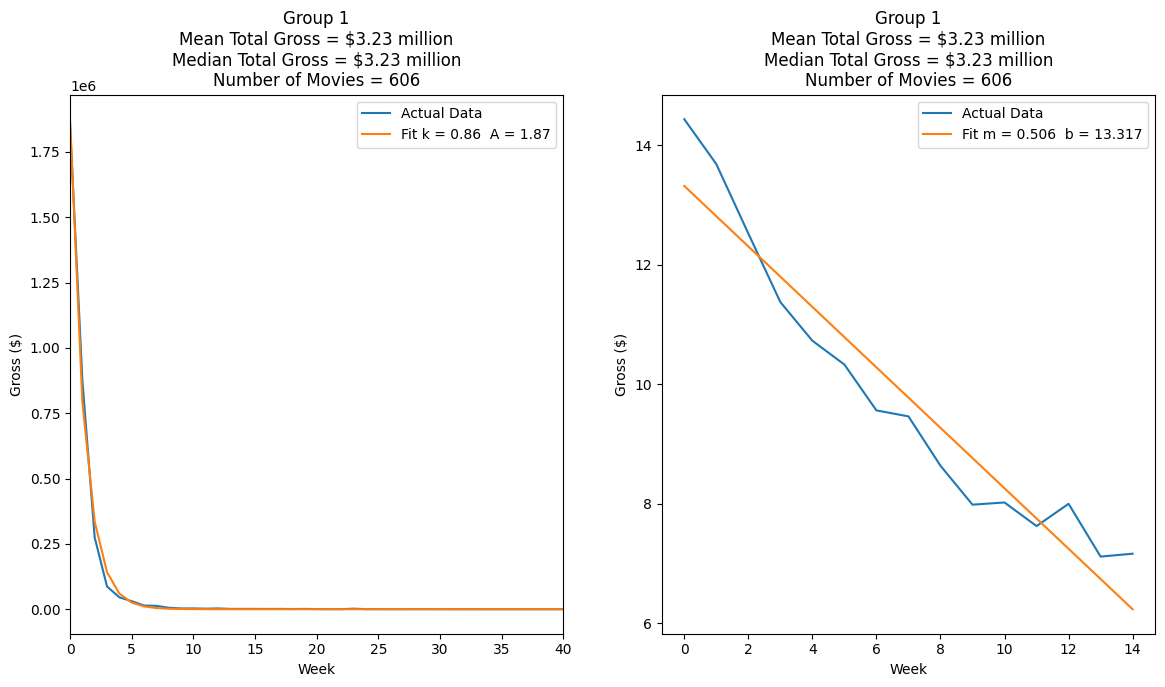

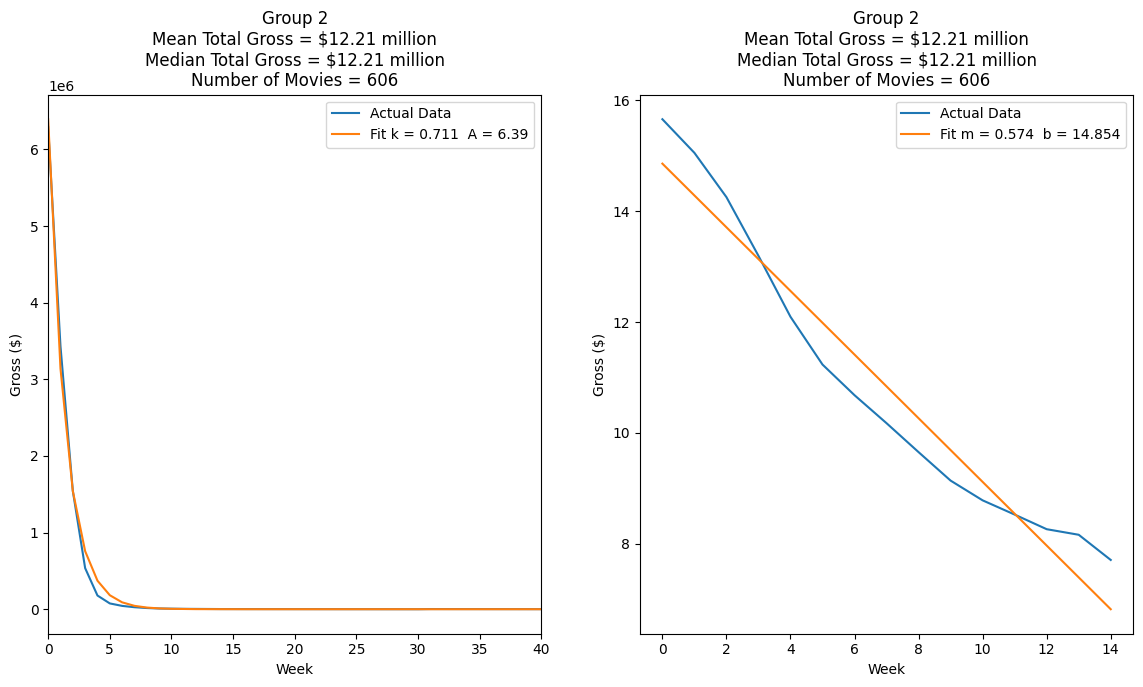

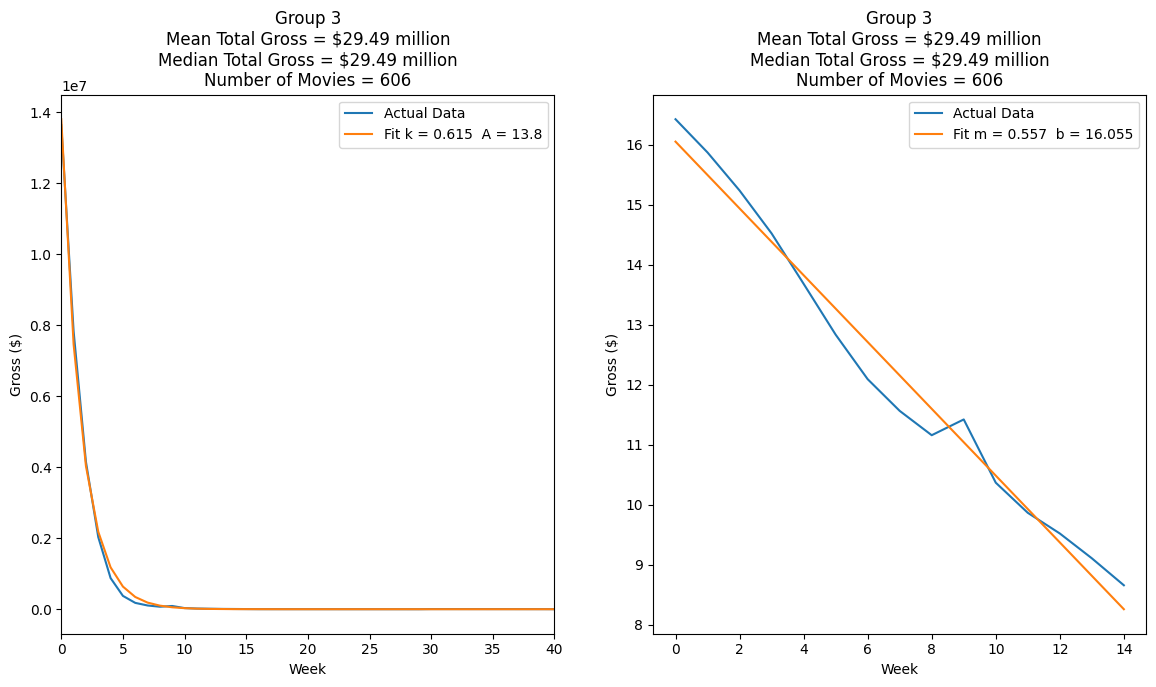

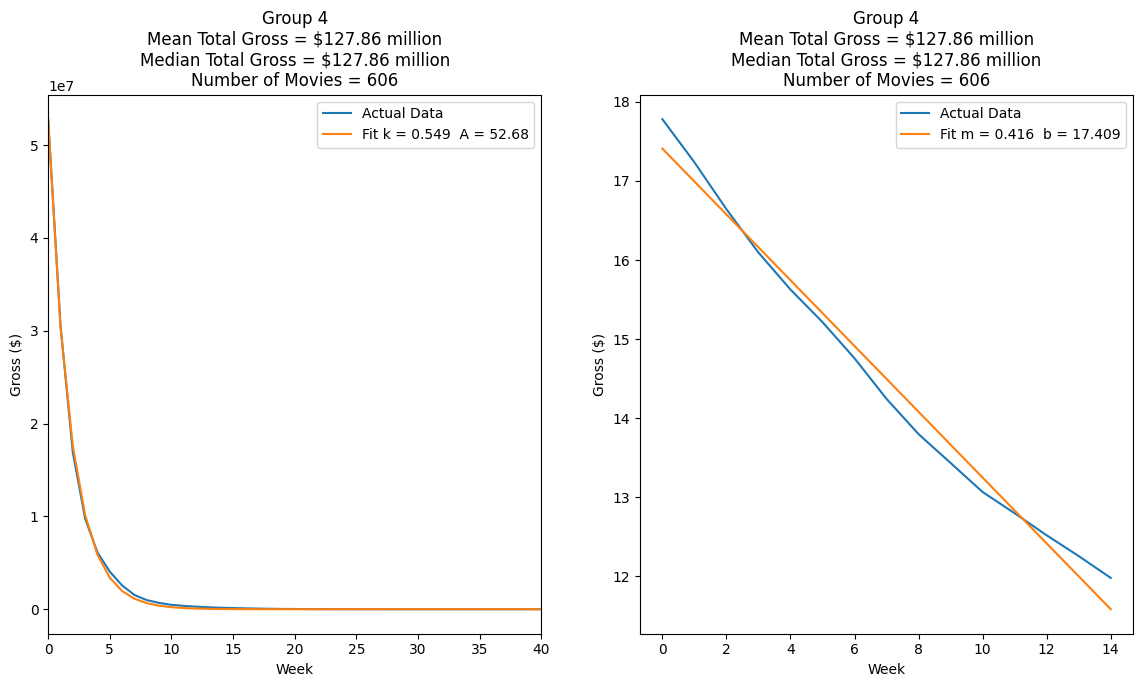

In [33]:
def avg_plots_for_groups(groups):
    for i in range(0,len(groups)):
        average_array = np.zeros(1000)
        for movie in groups[i]:
            weeks = grossing_data[movie][0]
            grosses = grossing_data[movie][1]
            for j in range(0,len(weeks)):
                average_array[weeks[j]] += grosses[j]
        average_array = average_array/len(groups[i])
        yvals = []
        xvals = []
        for j in range(0,1000):
            if average_array[j] > 0:
                xvals += [float(j)]
                yvals += [average_array[j]]
        popt_exp = curve_fit(exp_func, np.array(xvals), np.array(yvals), bounds = (0,np.inf))[0]
        plt.figure(figsize=(14,7))
        plt.subplot(1,2,1)
        plt.plot(xvals,yvals)
        plt.plot(xvals,exp_func(np.array(xvals),popt_exp[0],popt_exp[1]))
        plt.xlim([0,40])
        plt.xlabel("Week")
        plt.ylabel("Gross ($)")
        plt.title("Group "+str(i+1)+'\n'+"Mean Total Gross = $"+str(round(np.mean(group_data[i])/1000000,2))+" million"+'\n'+
            "Median Total Gross = $"+str(round(np.mean(group_data[i])/1000000,2))+" million"+'\n'+"Number of Movies = "+str(len(groups[i])))
        plt.legend(["Actual Data","Fit k = "+str(round(popt_exp[0],3))+"  A = "+str(round(popt_exp[1]/1000000,2))])

        xvals = xvals[:15]
        yvals = yvals[:15]
        popt_linear = curve_fit(linear_func, np.array(xvals), np.log(np.array(yvals)), bounds = (0,np.inf))[0]
        plt.subplot(1,2,2)
        plt.plot(xvals,np.log(yvals))
        plt.plot(xvals,linear_func(np.array(xvals),popt_linear[0],popt_linear[1]))
        # plt.xlim([0,40])
        plt.xlabel("Week")
        plt.ylabel("Gross ($)")
        plt.title("Group "+str(i+1)+'\n'+"Mean Total Gross = $"+str(round(np.mean(group_data[i])/1000000,2))+" million"+'\n'+
            "Median Total Gross = $"+str(round(np.mean(group_data[i])/1000000,2))+" million"+'\n'+"Number of Movies = "+str(len(groups[i])))
        plt.legend(["Actual Data","Fit m = "+str(round(popt_linear[0],3))+"  b = "+str(round(popt_linear[1],3))])
    plt.show()

avg_plots_for_groups(groups)

The functions below accepts the groups created above as input.
1. For groups_prediction1, movies are split into a training set and testing set (80/20). The grossing data for the training set movies is averaged and fit to an exponential to estimate the decay rate. This decay rate along with the first weeks gross is then used to predict the total gross for each movie in the test set. Plots created to show how well the fits follow the actual data and to show the errors returned by the prediction process. 
1. For groups_prediction1, movies are split into a training set and testing set (80/20). A decay rate is estimated for each movie in the training set and then these rates are averaged to acquire a final decay rate. This decay rate along with the first weeks gross is then used to predict the total gross for each movie in the test set. Plots created to show how well the fits follow the actual data and to show the errors returned by the prediction process. 

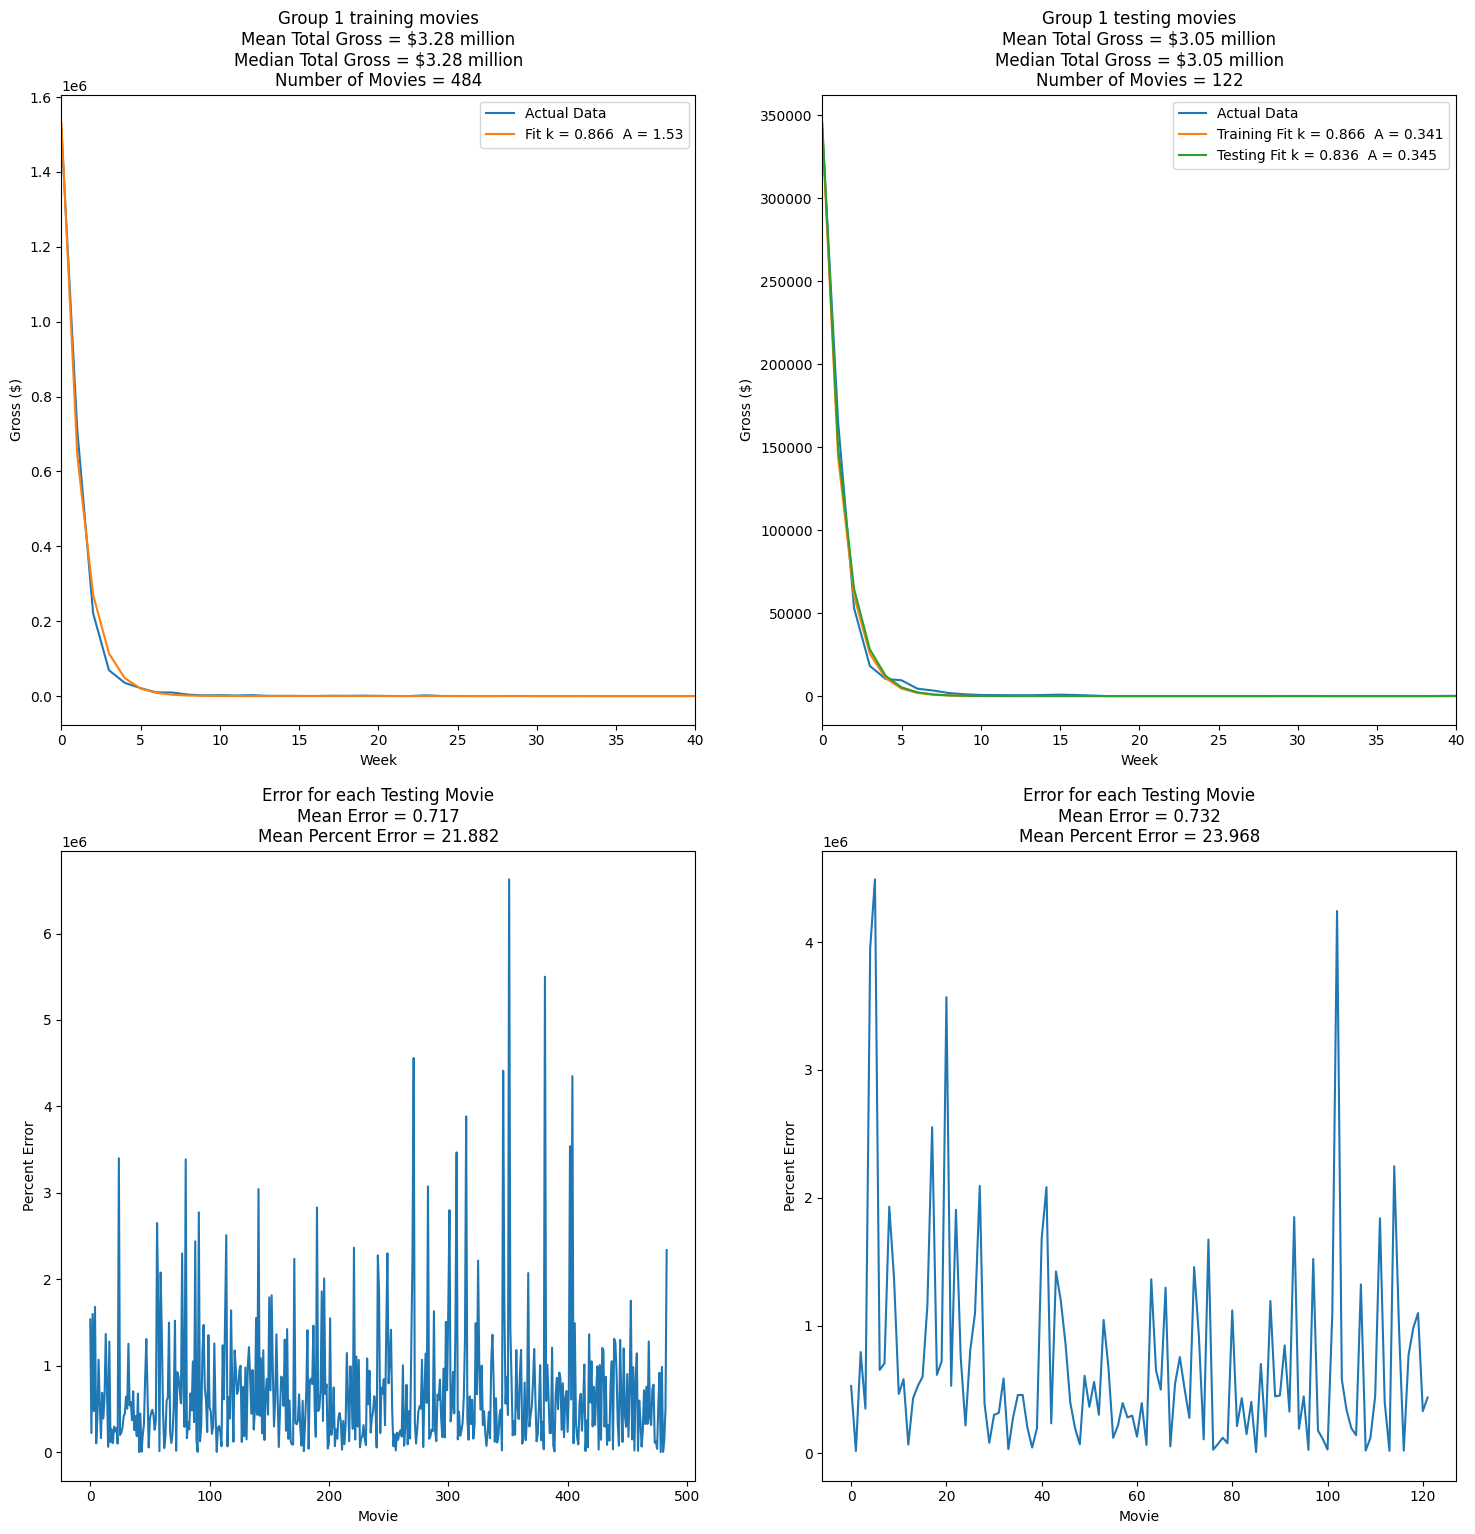

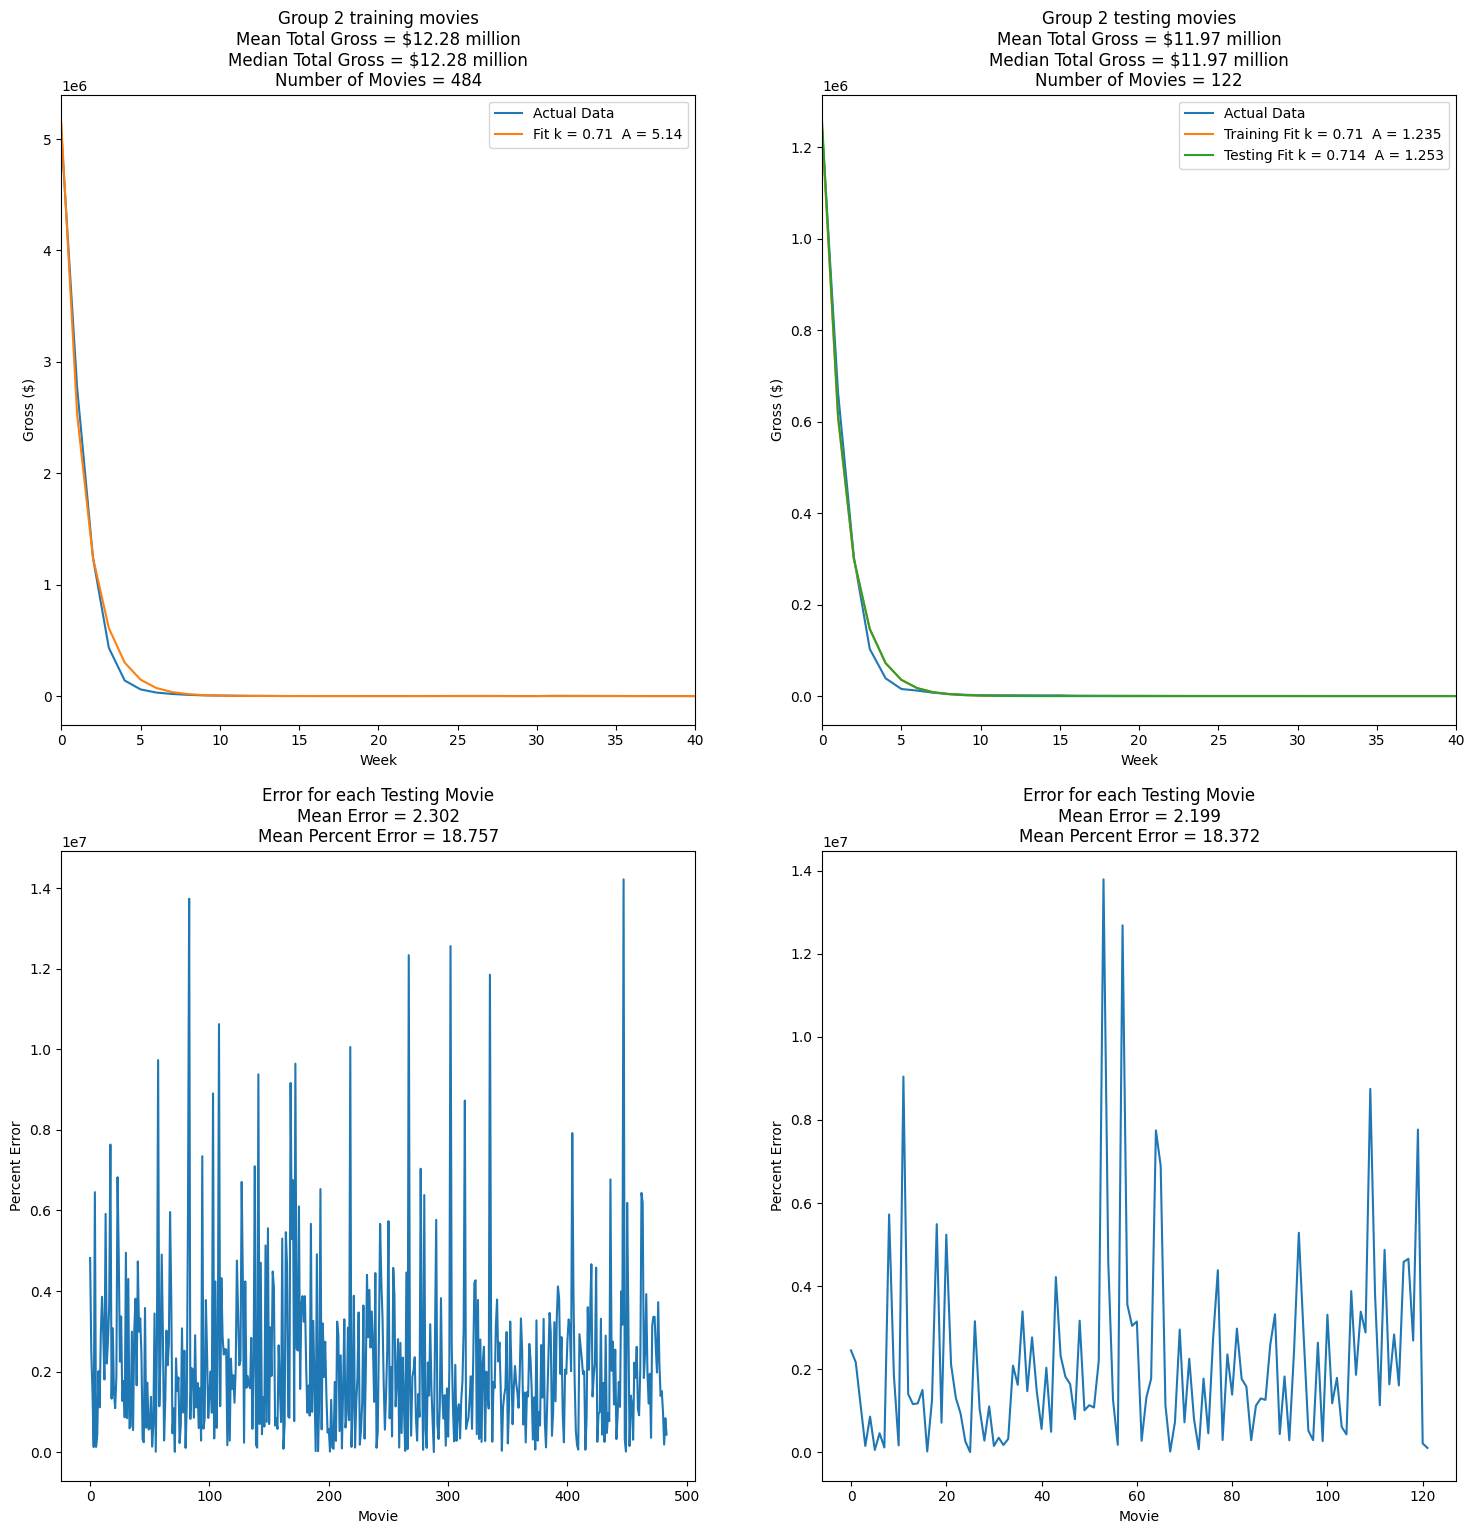

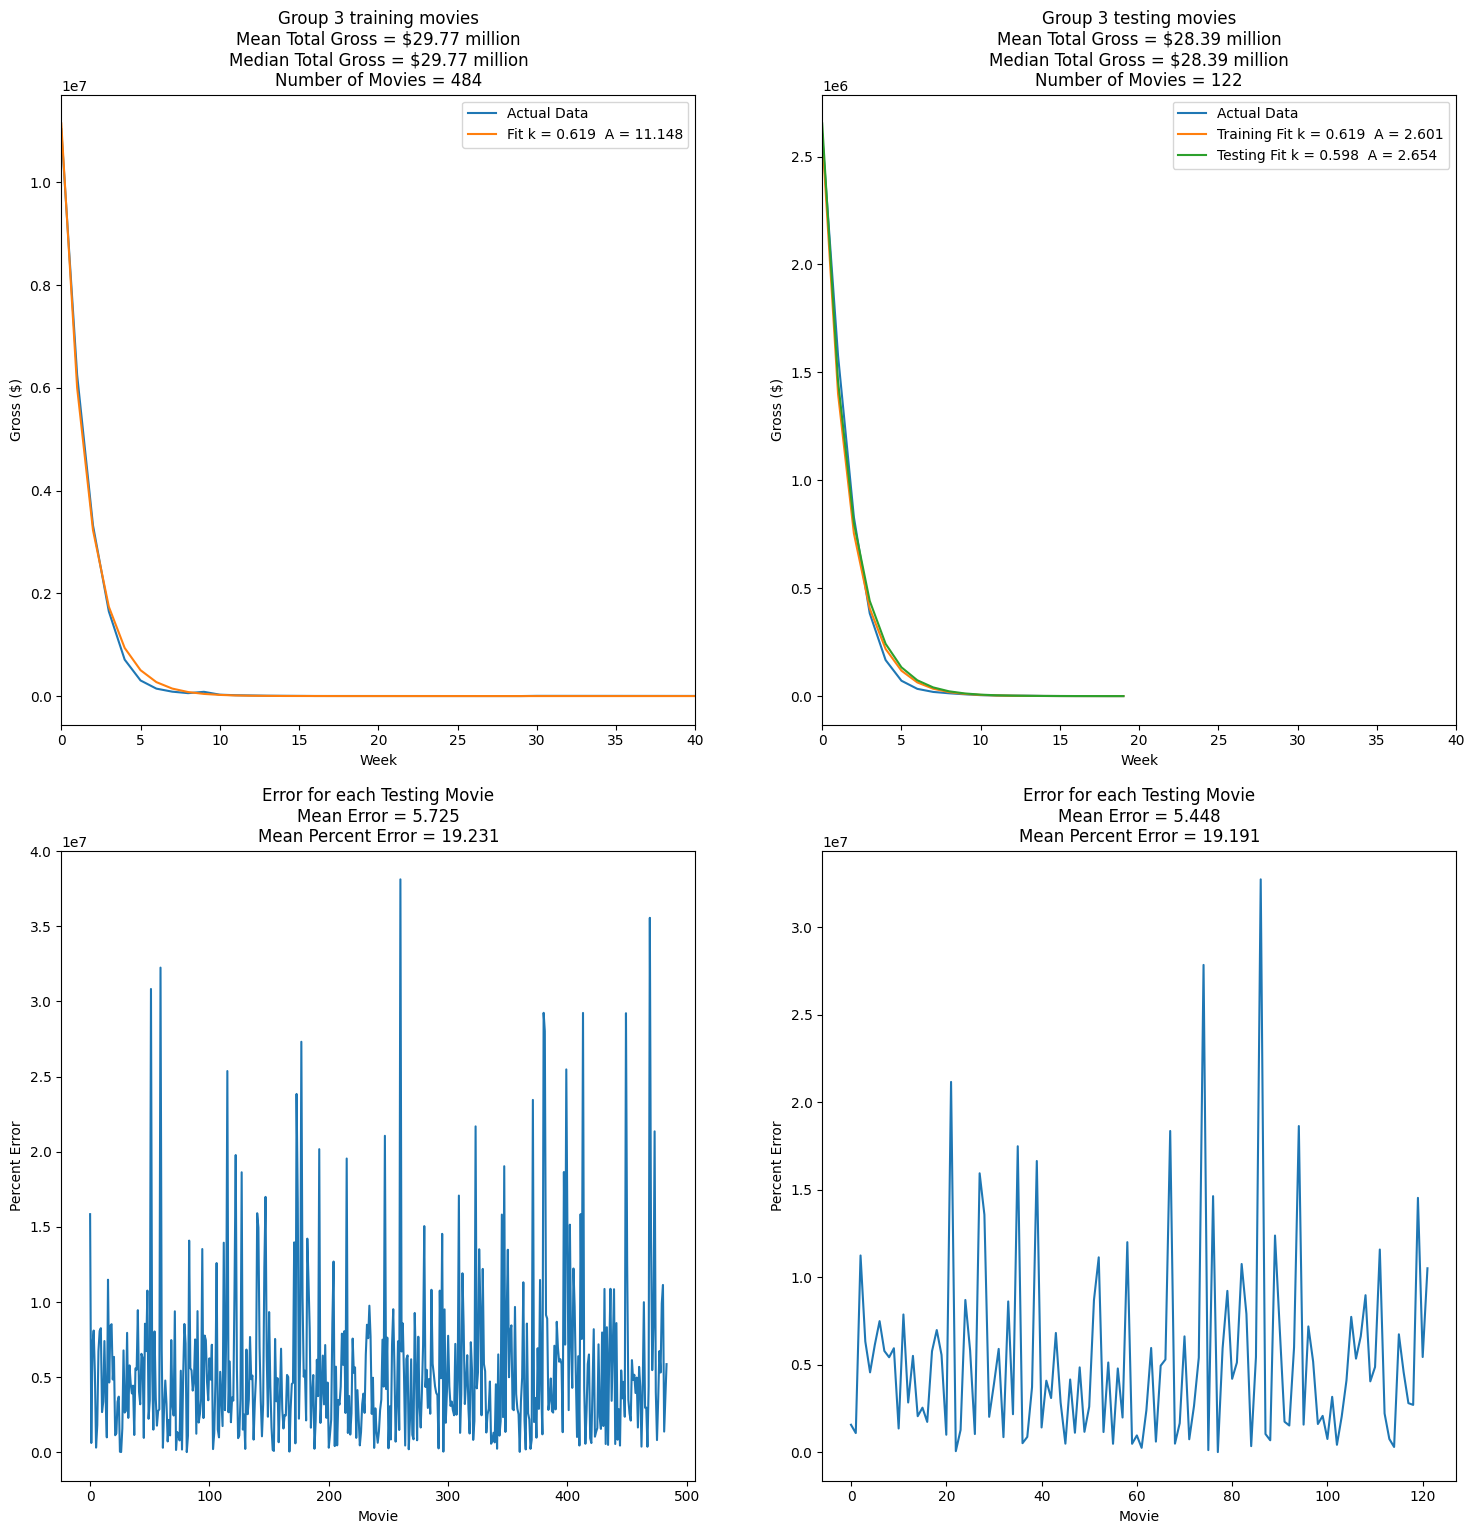

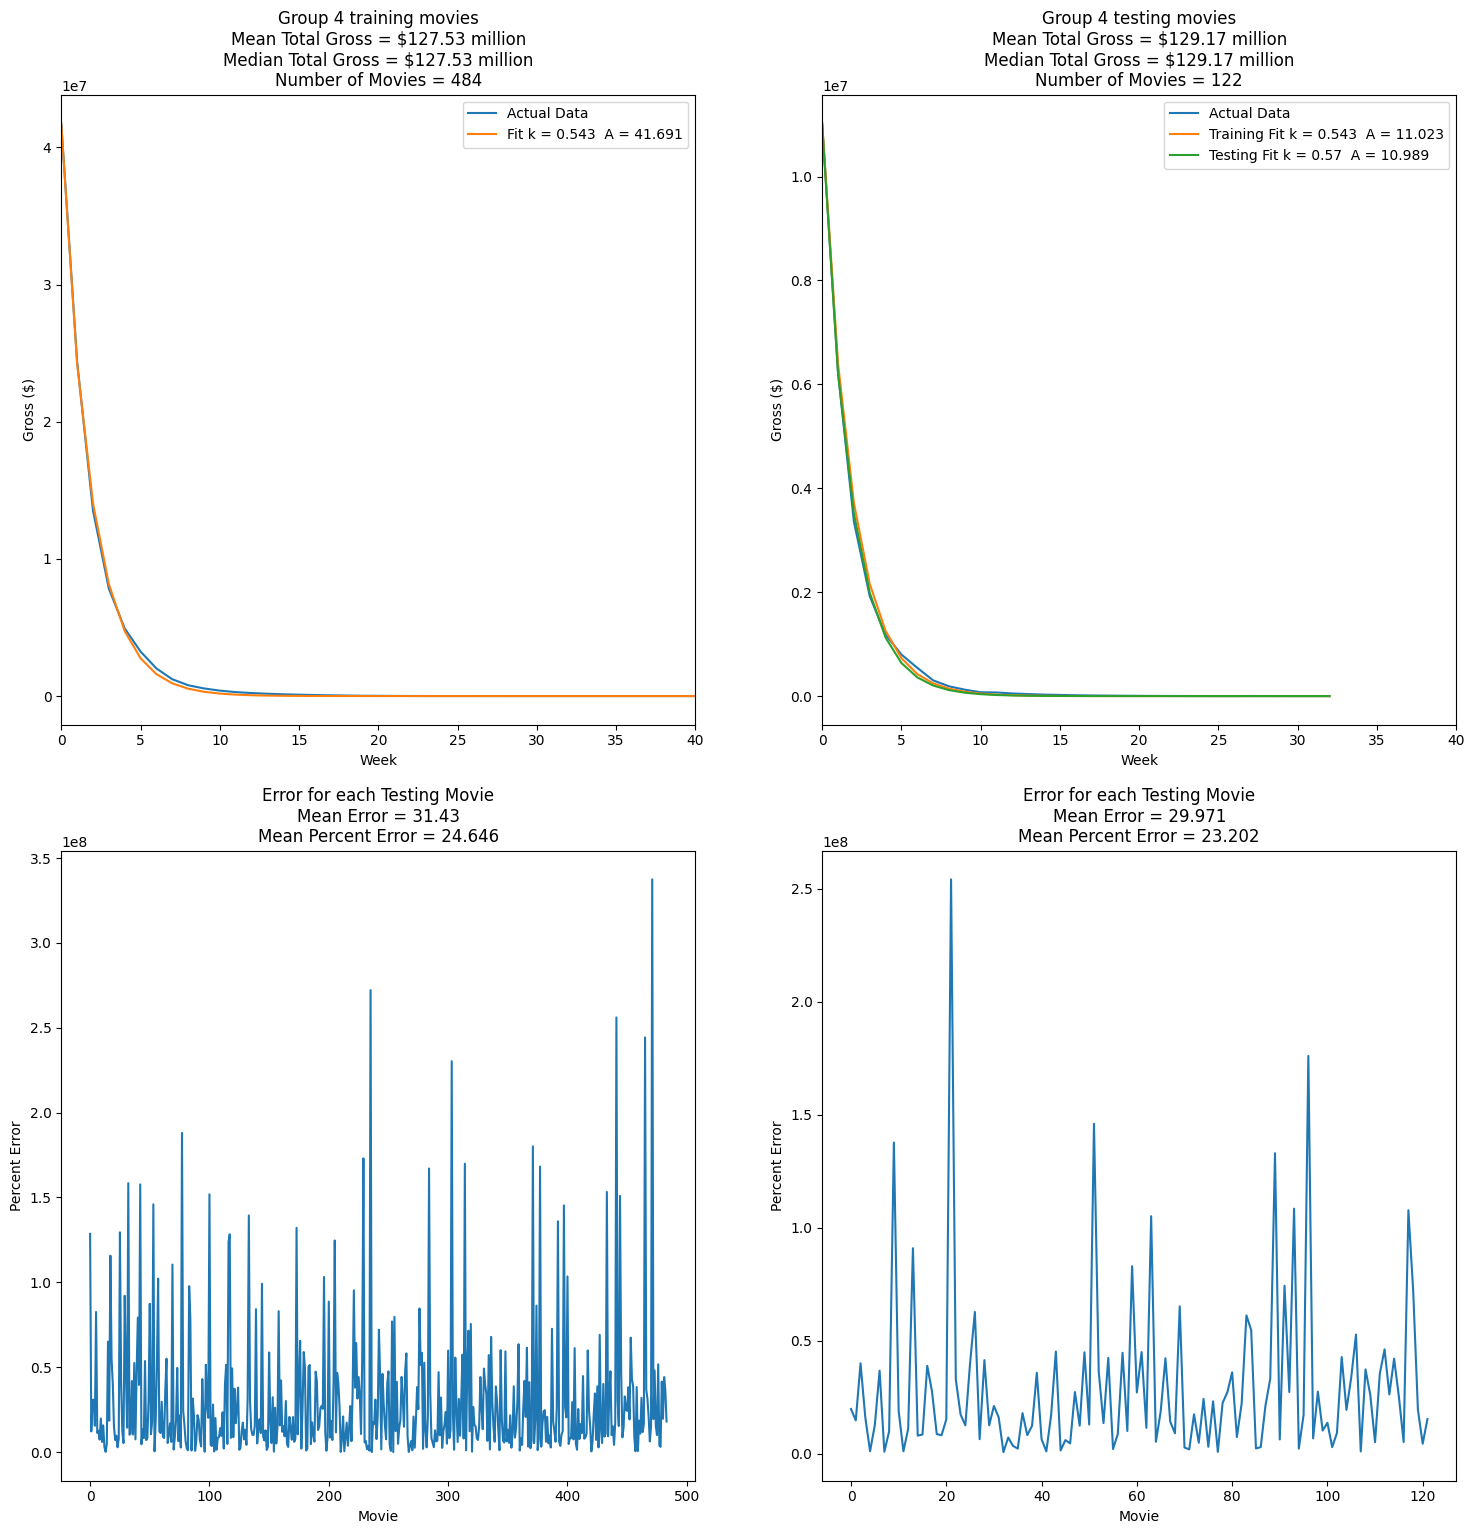

In [34]:
def groups_prediction1(groups):
    for i in range(0,len(groups)):
        # split each groups data into training and testing
        choices = [i for i in range(0,len(groups[i]))]
        split_size = int(.8*len(groups[i]))
        training_indices = random.sample(choices,split_size)
        testing_indices = [x for x in choices if x not in training_indices]
        training_movies = [groups[i][x] for x in training_indices]
        testing_movies = [groups[i][x] for x in testing_indices]
        training_total_gross_data = [total_gross[movie] for movie in training_movies]
        testing_total_gross_data = [total_gross[movie] for movie in testing_movies]

        # Training movies: Average data and estimate the paramters. Plot the data and the fit
        average_array = np.zeros(1000)
        for movie in training_movies:
            weeks = grossing_data[movie][0]
            grosses = grossing_data[movie][1]
            for j in range(0,len(weeks)):
                average_array[weeks[j]] += grosses[j]
        average_array = average_array/len(groups[i])
        yvals = []
        xvals = []
        for j in range(0,1000):
            if average_array[j] > 0:
                xvals += [float(j)]
                yvals += [average_array[j]]
        popt_train = curve_fit(exp_func, np.array(xvals), np.array(yvals), bounds = (0,np.inf))[0]
        plt.figure(figsize=(18,18))
        plt.subplot(2,2,1)
        plt.plot(xvals,yvals)
        plt.plot(xvals,exp_func(np.array(xvals),popt_train[0],popt_train[1]))
        plt.xlim([0,40])
        plt.xlabel("Week")
        plt.ylabel("Gross ($)")
        plt.title("Group "+str(i+1)+" training movies"+'\n'+"Mean Total Gross = $"+str(round(np.mean(training_total_gross_data)/1000000,2))+" million"+'\n'+
            "Median Total Gross = $"+str(round(np.mean(training_total_gross_data)/1000000,2))+" million"+'\n'+
            "Number of Movies = "+str(len(training_movies)))
        plt.legend(["Actual Data","Fit k = "+str(round(popt_train[0],3))+"  A = "+str(round(popt_train[1]/1000000,3))])

        # Testing movies: Average the data and plot the fit with the training paramters and with
        # testing data estimated paramters
        average_array = np.zeros(1000)
        for movie in testing_movies:
            weeks = grossing_data[movie][0]
            grosses = grossing_data[movie][1]
            for j in range(0,len(weeks)):
                average_array[weeks[j]] += grosses[j]
        average_array = average_array/len(groups[i])
        yvals = []
        xvals = []
        for j in range(0,1000):
            if average_array[j] > 0:
                xvals += [float(j)]
                yvals += [average_array[j]]
        popt_test = curve_fit(exp_func, np.array(xvals), np.array(yvals), bounds = (0,np.inf))[0]
        plt.subplot(2,2,2)
        plt.plot(xvals,yvals)
        plt.plot(xvals,exp_func(np.array(xvals),popt_train[0],yvals[0]))
        plt.plot(xvals,exp_func(np.array(xvals),popt_test[0],popt_test[1]))
        plt.xlim([0,40])
        plt.xlabel("Week")
        plt.ylabel("Gross ($)")
        plt.title("Group "+str(i+1)+" testing movies"+'\n'+"Mean Total Gross = $"+str(round(np.mean(testing_total_gross_data)/1000000,2))+" million"+'\n'+
            "Median Total Gross = $"+str(round(np.mean(testing_total_gross_data)/1000000,2))+" million"+'\n'+
            "Number of Movies = "+str(len(testing_movies)))
        plt.legend(["Actual Data",
            "Training Fit k = "+str(round(popt_train[0],3))+"  A = "+str(round(yvals[0]/1000000,3)),
            "Testing Fit k = "+str(round(popt_test[0],3))+"  A = "+str(round(popt_test[1]/1000000,3))])
        
        # Predict total gross of training movies using the decay rate estimated using the training
        # movies and the first weeks grossing for each testing movie.
        error_train = [abs(total_gross_calc(grossing_data[training_movies[0]][1][0],popt_train[0]) - total_gross[training_movies[0]])]
        for j in range(1,len(training_movies)):
            error_train += [abs(total_gross_calc(grossing_data[training_movies[j]][1][0],popt_train[0]) - total_gross[training_movies[j]])]
        plt.subplot(2,2,3)
        plt.plot(range(len(training_movies)),error_train)
        plt.xlabel("Movie")
        plt.ylabel("Percent Error")
        mean_train_error = np.mean(error_train)
        plt.title("Error for each Testing Movie"+'\n'+"Mean Error = "+str(round(mean_train_error/1000000,3))+'\n'+
            "Mean Percent Error = "+str(round((mean_train_error/np.mean(training_total_gross_data))*100,3)))

        # Predict total gross of testing movies using the decay rate estimated using the training
        # movies and the first weeks grossing for each testing movie.
        error_test = [abs(total_gross_calc(grossing_data[testing_movies[0]][1][0],popt_train[0]) - total_gross[testing_movies[0]])]
        for j in range(1,len(testing_movies)):
            error_test += [abs(total_gross_calc(grossing_data[testing_movies[j]][1][0],popt_train[0]) - total_gross[testing_movies[j]])]
        plt.subplot(2,2,4)
        plt.plot(range(len(testing_movies)),error_test)
        plt.xlabel("Movie")
        plt.ylabel("Percent Error")
        mean_test_error = np.mean(error_test)
        plt.title("Error for each Testing Movie"+'\n'+"Mean Error = "+str(round(mean_test_error/1000000,3))+'\n'+
            "Mean Percent Error = "+str(round((mean_test_error/np.mean(testing_total_gross_data))*100,3)))
    plt.show()

groups_prediction1(groups)

def groups_prediction2(groups):
    for i in range(0,len(groups)):
        # split each groups data into training and testing
        choices = [i for i in range(0,len(groups[i]))]
        split_size = int(.8*len(groups[i]))
        training_indices = random.sample(choices,split_size)
        testing_indices = [x for x in choices if x not in training_indices]
        training_movies = [groups[i][x] for x in training_indices]
        testing_movies = [groups[i][x] for x in testing_indices]
        training_total_gross_data = [total_gross[movie] for movie in training_movies]
        testing_total_gross_data = [total_gross[movie] for movie in testing_movies]

        # Training movies: gettting a decay constant by means of averaging all decay constants
        # instead of fitting the average data.
        train_avg_decay = 0
        train_avg_A = 0
        for movie in training_movies:
            weeks = grossing_data[movie][0]
            grosses = grossing_data[movie][1]
            params = curve_fit(exp_func, np.array(weeks), np.array(grosses), bounds = (0,np.inf))[0]
            train_avg_decay += params[0]
            train_avg_A += params[1]
        train_avg_decay = train_avg_decay/len(training_movies)
        train_avg_A = train_avg_A/len(training_movies)

        # Training movies: Average data and estimate the paramters. Plot the data and the fit
        average_array = np.zeros(1000)
        for movie in training_movies:
            weeks = grossing_data[movie][0]
            grosses = grossing_data[movie][1]
            for j in range(0,len(weeks)):
                average_array[weeks[j]] += grosses[j]
        average_array = average_array/len(groups[i])
        yvals = []
        xvals = []
        for j in range(0,1000):
            if average_array[j] > 0:
                xvals += [float(j)]
                yvals += [average_array[j]]
        popt_train = curve_fit(exp_func, np.array(xvals), np.array(yvals), bounds = (0,np.inf))[0]
        plt.figure(figsize=(18,18))
        plt.subplot(2,2,1)
        plt.plot(xvals,yvals)
        plt.plot(xvals,exp_func(np.array(xvals),popt_train[0],popt_train[1]))
        plt.plot(xvals,exp_func(np.array(xvals),train_avg_decay,train_avg_A))
        plt.xlim([0,40])
        plt.xlabel("Week")
        plt.ylabel("Gross ($)")
        plt.title("Group "+str(i+1)+" training movies"+'\n'+"Mean Total Gross = $"+str(round(np.mean(training_total_gross_data)/1000000,2))+" million"+'\n'+
            "Median Total Gross = $"+str(round(np.mean(training_total_gross_data)/1000000,2))+" million"+'\n'+
            "Number of Movies = "+str(len(training_movies)))
        plt.legend(["Actual Data","Fit k = "+str(round(popt_train[0],3))+"  A = "+str(round(popt_train[1]/1000000,3)),
                    "Fit k = "+str(round(train_avg_decay,3))+"  A = "+str(round(train_avg_A/1000000,3))])

        # Testing movies: gettting a decay constant by means of averaging all decay constants
        # instead of fitting the average data.
        test_avg_decay,test_avg_A = 0,0
        for movie in testing_movies:
            weeks = grossing_data[movie][0]
            grosses = grossing_data[movie][1]
            params = curve_fit(exp_func, np.array(weeks), np.array(grosses), bounds = (0,np.inf))[0]
            test_avg_decay += params[0]
            test_avg_A += params[1]
        test_avg_decay = test_avg_decay/len(testing_movies)
        test_avg_A = test_avg_A/len(testing_movies)

        # Testing movies: Average the data and plot the fit with the training paramters and with
        # testing data estimated paramters
        average_array = np.zeros(1000)
        for movie in testing_movies:
            weeks = grossing_data[movie][0]
            grosses = grossing_data[movie][1]
            for j in range(0,len(weeks)):
                average_array[weeks[j]] += grosses[j]
        average_array = average_array/len(groups[i])
        yvals = []
        xvals = []
        for j in range(0,1000):
            if average_array[j] > 0:
                xvals += [float(j)]
                yvals += [average_array[j]]
        popt_test = curve_fit(exp_func, np.array(xvals), np.array(yvals), bounds = (0,np.inf))[0]
        plt.subplot(2,2,2)
        plt.plot(xvals,yvals)
        plt.plot(xvals,exp_func(np.array(xvals),popt_train[0],yvals[0]))
        plt.plot(xvals,exp_func(np.array(xvals),train_avg_decay,yvals[0]))
        plt.plot(xvals,exp_func(np.array(xvals),popt_test[0],popt_test[1]))
        plt.plot(xvals,exp_func(np.array(xvals),test_avg_decay,test_avg_A))
        plt.xlim([0,40])
        plt.xlabel("Week")
        plt.ylabel("Gross ($)")
        plt.title("Group "+str(i+1)+" testing movies"+'\n'+"Mean Total Gross = $"+str(round(np.mean(testing_total_gross_data)/1000000,2))+" million"+'\n'+
            "Median Total Gross = $"+str(round(np.mean(testing_total_gross_data)/1000000,2))+" million"+'\n'+
            "Number of Movies = "+str(len(testing_movies)))
        plt.legend(["Actual Data",
            "Training Fit k = "+str(round(popt_train[0],3))+"  A = "+str(round(yvals[0]/1000000,3)),
            "Training Fit k = "+str(round(train_avg_decay,3))+"  A = "+str(round(yvals[0]/1000000,3)),
            "Testing Fit k = "+str(round(popt_test[0],3))+"  A = "+str(round(popt_test[1]/1000000,3)),
            "Testing Fit k = "+str(round(test_avg_decay,3))+"  A = "+str(round(test_avg_A/1000000,3))])
        
        # Predict total gross of training movies using the decay rate estimated using the training
        # movies and the first weeks grossing for each testing movie.
        error_train = [abs(total_gross_calc(grossing_data[training_movies[0]][1][0],train_avg_decay) - total_gross[training_movies[0]])]
        #error_train = [total_gross_calc(grossing_data[training_movies[0]][1][0],train_avg_decay) - total_gross[training_movies[0]]]
        for j in range(1,len(training_movies)):
            error_train += [abs(total_gross_calc(grossing_data[training_movies[j]][1][0],train_avg_decay) - total_gross[training_movies[j]])]
            #error_train += [total_gross_calc(grossing_data[training_movies[j]][1][0],train_avg_decay) - total_gross[training_movies[j]]]
        plt.subplot(2,2,3)
        plt.plot(range(len(training_movies)),error_train)
        plt.xlabel("Movie")
        plt.ylabel("Percent Error")
        mean_train_error = np.mean(error_train)
        plt.title("Error for each Testing Movie"+'\n'+"Mean Error = "+str(round(mean_train_error/1000000,3))+'\n'+
            "Mean Percent Error = "+str(round((mean_train_error/np.mean(training_total_gross_data))*100,3)))

        # Predict total gross of testing movies using the decay rate estimated using the training
        # movies and the first weeks grossing for each testing movie.
        error_test = [abs(total_gross_calc(grossing_data[testing_movies[0]][1][0],train_avg_decay) - total_gross[testing_movies[0]])]
        #error_test = [total_gross_calc(grossing_data[testing_movies[0]][1][0],train_avg_decay) - total_gross[testing_movies[0]]]
        for j in range(1,len(testing_movies)):
            error_test += [abs(total_gross_calc(grossing_data[testing_movies[j]][1][0],train_avg_decay) - total_gross[testing_movies[j]])]
            #error_test += [total_gross_calc(grossing_data[testing_movies[j]][1][0],train_avg_decay) - total_gross[testing_movies[j]]]
        plt.subplot(2,2,4)
        plt.plot(range(len(testing_movies)),error_test)
        plt.xlabel("Movie")
        plt.ylabel("Percent Error")
        mean_test_error = np.mean(error_test)
        plt.title("Error for each Testing Movie"+'\n'+"Mean Error = "+str(round(mean_test_error/1000000,3))+'\n'+
            "Mean Percent Error = "+str(round((mean_test_error/np.mean(testing_total_gross_data))*100,3)))
    plt.show()

# groups_prediction2(groups)

The functions below behave the same as the functions above except all movies in each group are cycled through with the current movie being the singular test movie and all other movies in the group being the training movies. 

In [27]:
def LOO_groups_prediction1(groups):
    collective_errors = [[] for i in range(len(groups))]
    collective_percent_errors = [[] for i in range(len(groups))]
    for i in range(0,len(groups)):
        for j in range(0,len(groups[i])):
            test_movie = groups[i][j]
            train_movies = [movie for movie in groups[i] if movie != test_movie]
            average_array = np.zeros(1000)
            for movie in train_movies:
                weeks = grossing_data[movie][0]
                grosses = grossing_data[movie][1]
                for k in range(0,len(weeks)):
                    average_array[weeks[k]] += grosses[k]
            average_array = average_array/len(groups[i])
            yvals = []
            xvals = []
            for k in range(0,1000):
                if average_array[k] > 0:
                    xvals += [float(k)]
                    yvals += [average_array[k]]
            popt = curve_fit(exp_func, np.array(xvals), np.array(yvals), bounds = (0,np.inf))[0]
            prediction = total_gross_calc(grossing_data[test_movie][1][0],popt[0])
            collective_errors[i] += [ abs(prediction - total_gross[test_movie]) ]
            collective_percent_errors[i] += [abs((prediction - total_gross[test_movie])/total_gross[test_movie])*100]
    return collective_errors, collective_percent_errors

collective_errors, collective_percent_errors = LOO_groups_prediction1(groups)

def LOO_groups_prediction2(groups):
    collective_errors = [[] for i in range(len(groups))]
    collective_percent_errors = [[] for i in range(len(groups))]
    for i in range(0,len(groups)):
        for j in range(0,len(groups[i])):
            test_movie = groups[i][j]
            train_movies = [movie for movie in groups[i] if movie != test_movie]
            avg_decay = 0
            for movie in train_movies:
                avg_decay += decay_rates[movie]
            avg_decay = avg_decay/len(train_movies)
            prediction = total_gross_calc(grossing_data[test_movie][1][0],avg_decay)
            collective_errors[i] += [ abs(prediction - total_gross[test_movie]) ]
            collective_percent_errors[i] += [abs((prediction - total_gross[test_movie])/total_gross[test_movie])*100]
    return collective_errors, collective_percent_errors

# collective_errors, collective_percent_errors = LOO_groups_prediction2(groups) 

This loops takes the errors returned by the LOO functions above and plots the results. 

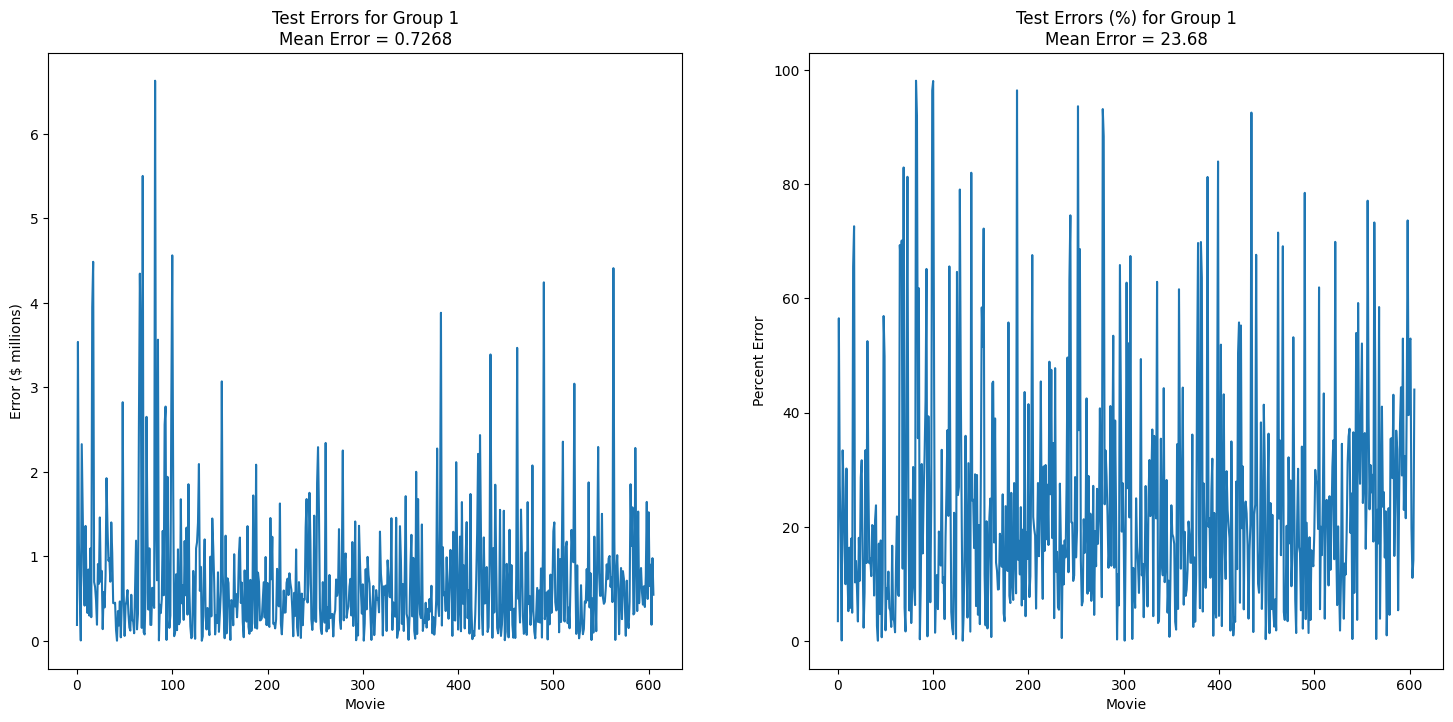

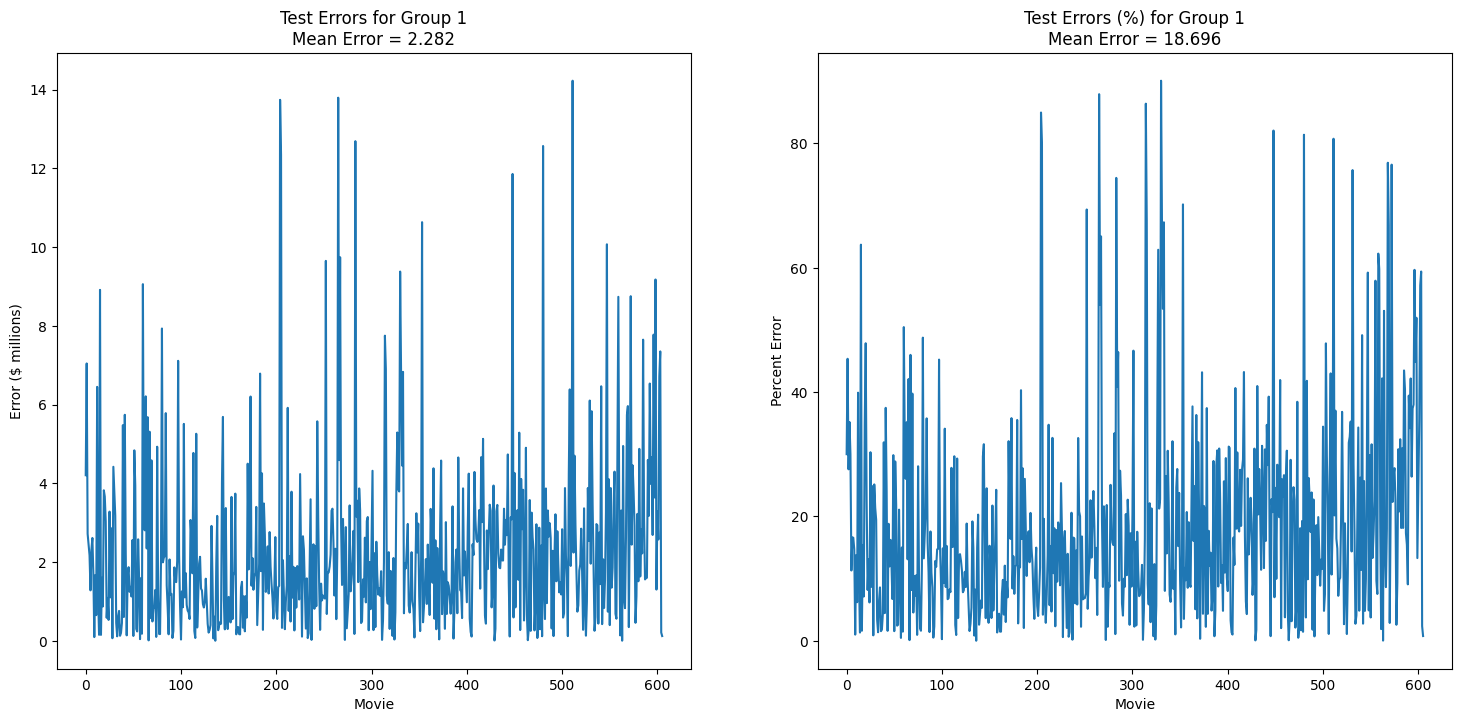

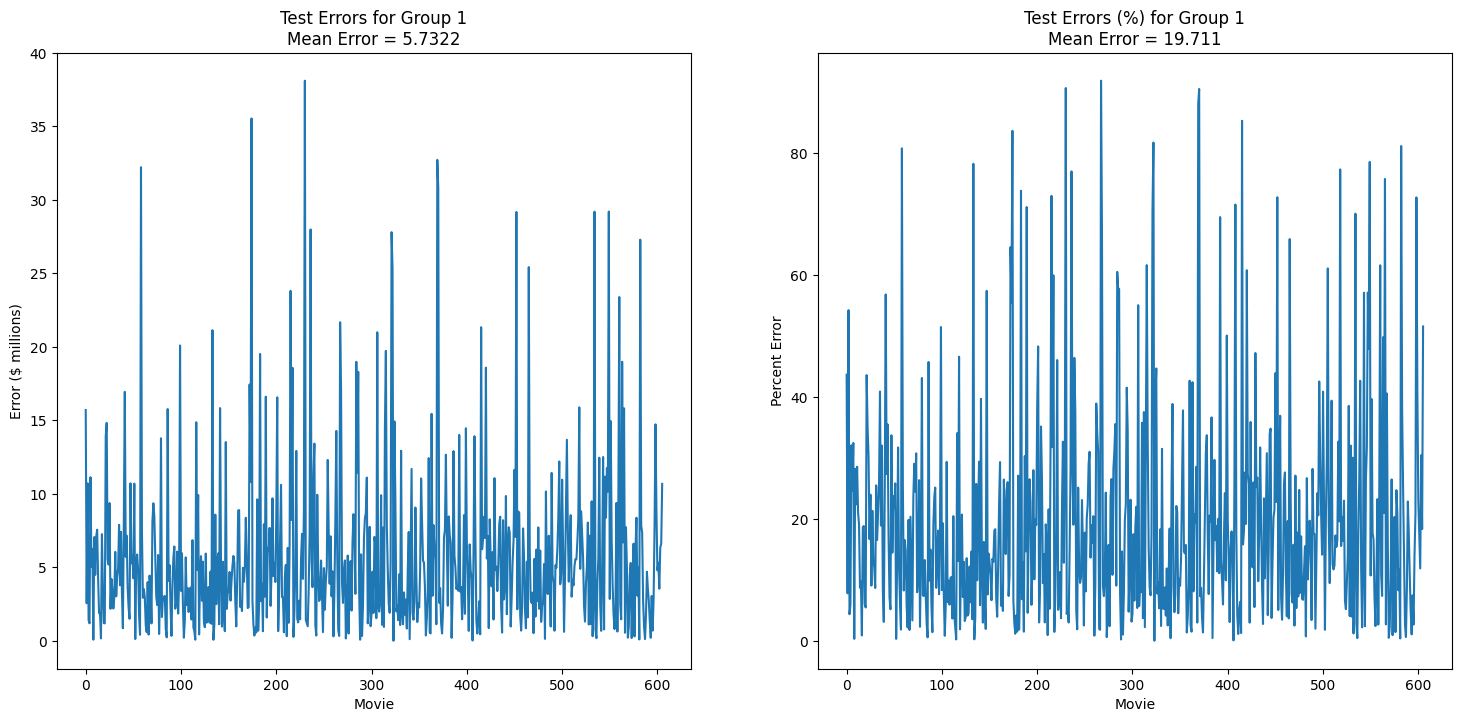

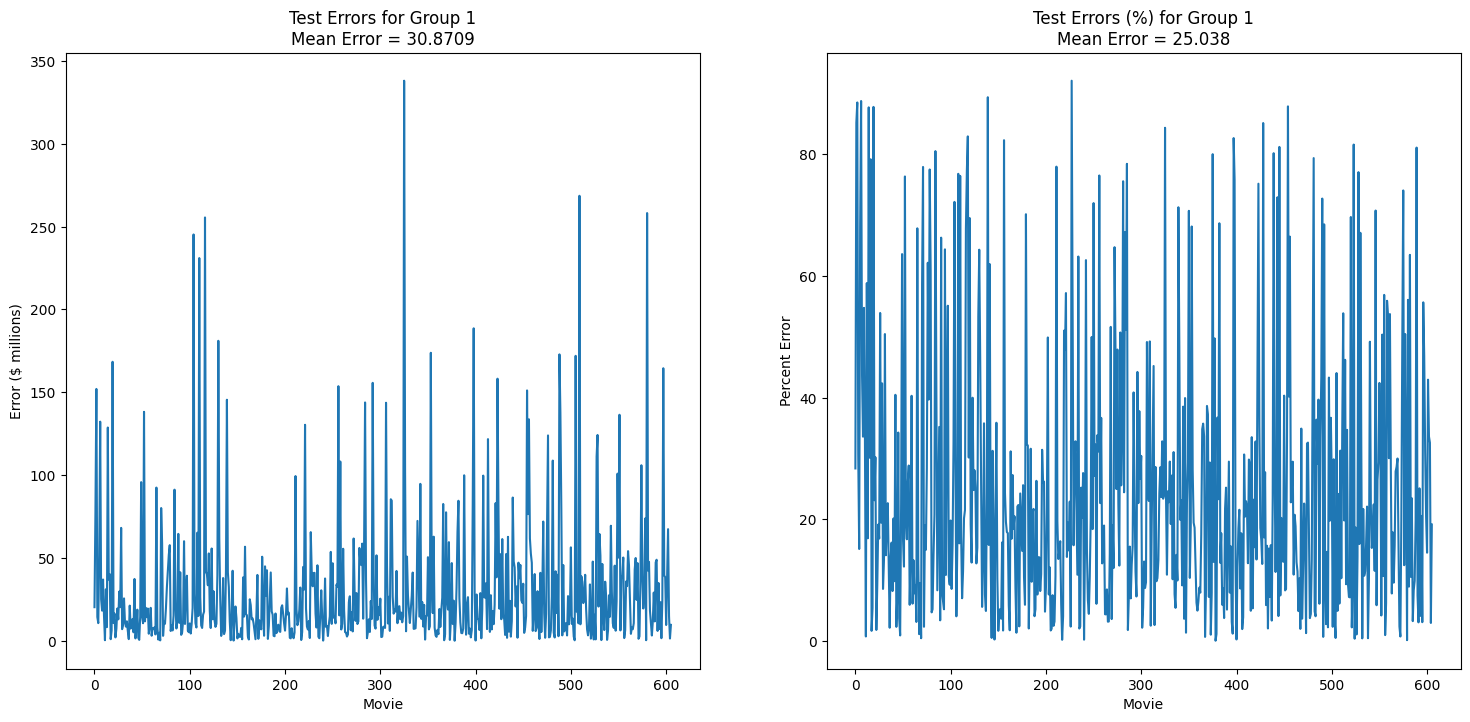

In [28]:
for i in range(0,len(groups)):
    plt.figure(figsize=(18,8))
    plt.subplot(1,2,1)
    X = range(len(collective_errors[i]))
    plt.plot(X,np.array(collective_errors[i])/1000000)
    plt.title("Test Errors for Group 1"+'\n'+"Mean Error = "+str(round(np.mean(np.array(collective_errors[i]))/1000000,4)))
    plt.xlabel("Movie")
    plt.ylabel("Error ($ millions)")

    plt.subplot(1,2,2)
    plt.plot(X,collective_percent_errors[i])
    # print(collective_percent_errors[i])
    # plt.ylim([-3,3])
    plt.title("Test Errors (%) for Group 1"+'\n'+"Mean Error = "+str(round(np.mean(np.array(collective_percent_errors[i])),3)))
    plt.xlabel("Movie")
    plt.ylabel("Percent Error")
plt.show()


This cell performs the LOO prediction process for all movies and plots the results. 

In [ ]:
def LOO_all_movies_prediction(groups):
    collective_errors = [[] for i in range(len(groups))]
    collective_percent_errors = [[] for i in range(len(groups))]
    for i in range(0,len(groups)):
        for j in range(0,len(groups[i])):
            test_movie = groups[i][j]
            train_movies = [movie for movie in groups[i] if movie != test_movie]
            average_array = np.zeros(1000)
            for movie in train_movies:
                weeks = grossing_data[movie][0]
                grosses = grossing_data[movie][1]
                for k in range(0,len(weeks)):
                    average_array[weeks[k]] += grosses[k]
            average_array = average_array/len(groups[i])
            yvals = []
            xvals = []
            for k in range(0,1000):
                if average_array[k] > 0:
                    xvals += [float(k)]
                    yvals += [average_array[k]]
            popt = curve_fit(exp_func, np.array(xvals), np.array(yvals), bounds = (0,np.inf))[0]
            prediction = total_gross_calc(grossing_data[test_movie][1][0],popt[0])
            collective_errors[i] += [ abs(prediction - total_gross[test_movie]) ]
            collective_percent_errors[i] += [abs((prediction - total_gross[test_movie])/total_gross[test_movie])*100]
    return collective_errors, collective_percent_errors

collective_errors, collective_percent_errors = LOO_all_movies_prediction([movies]) 


plt.figure(figsize=(18,8))
plt.subplot(1,2,1)
X = range(len(collective_errors[0]))
plt.plot(X,np.array(collective_errors[0])/1000000)
plt.title("Test Errors for Group 1"+'\n'+"Mean Error = "+str(round(np.mean(np.array(collective_errors[0]))/1000000,4)))
plt.xlabel("Movie")
plt.ylabel("Error ($ millions)")

plt.subplot(1,2,2)
plt.plot(X,collective_percent_errors[0])
print(collective_percent_errors[0])
# plt.ylim([-3,3])
plt.title("Test Errors (%) for Group 1"+'\n'+"Mean Error = "+str(round(np.mean(np.array(collective_percent_errors[0])),3)))
plt.xlabel("Movie")
plt.ylabel("Percent Error")
plt.show